# AVI-DYS Time Series Classification

## Import Libraries

In [27]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [28]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [29]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [30]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]


## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [31]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [32]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [33]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

In [34]:
# Create a list of DIS categories for the confusion matrices and the classifaction report
target_names = ['DIS-0','DIS-1','DIS-2','DIS-3','DIS-4']
class_names = ['DIS-0','DIS-1','DIS-2','DIS-3','DIS-4']

### Fit models using a 70-30 stratified train-test split

#### Predict the Dystonia Duration Scores

In [35]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  16:57:01 29/05/2023
STC train estimate  16:57:28 29/05/2023
STC weight = 0.26486491436208415
DrCIF  16:57:51 29/05/2023
DrCIF train estimate  16:57:57 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  16:58:27 29/05/2023
Arsenal train estimate  16:58:44 29/05/2023
Arsenal weight = 0.23419012939490635
TDE  16:59:06 29/05/2023
TDE train estimate  16:59:06 29/05/2023
TDE weight = 0.11869262366844034


Create the confusion matrix

Confusion Matrix
[[ 3  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0 14]]


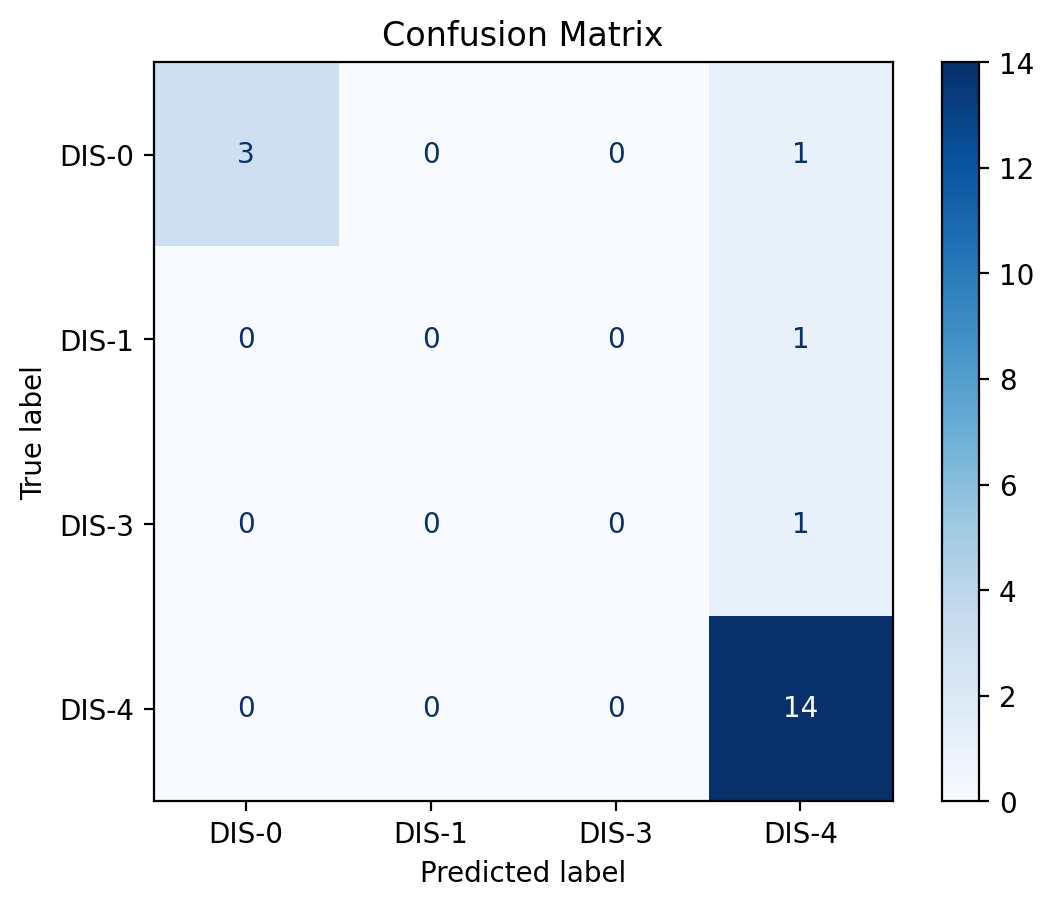

In [36]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['DIS-0','DIS-1','DIS-3','DIS-4'],
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [37]:
print(classification_report(y_test, y_pred,
                            target_names=['DIS-0','DIS-1','DIS-3','DIS-4']))

              precision    recall  f1-score   support

       DIS-0       1.00      0.75      0.86         4
       DIS-1       0.00      0.00      0.00         1
       DIS-3       0.00      0.00      0.00         1
       DIS-4       0.82      1.00      0.90        14

    accuracy                           0.85        20
   macro avg       0.46      0.44      0.44        20
weighted avg       0.78      0.85      0.80        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict the Dystonia Amplitude Scores

In [38]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  17:00:39 29/05/2023
STC train estimate  17:01:16 29/05/2023
STC weight = 0.1372779542668873
DrCIF  17:01:39 29/05/2023
DrCIF train estimate  17:01:44 29/05/2023
DrCIF weight = 0.0872426217030385
Arsenal  17:02:15 29/05/2023
Arsenal train estimate  17:02:32 29/05/2023
Arsenal weight = 0.15796492472511178
TDE  17:02:52 29/05/2023
TDE train estimate  17:02:52 29/05/2023
TDE weight = 0.0740992206288571


Create the confusion matrix

Confusion Matrix
[[4 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 4]
 [1 0 0 0 9]]


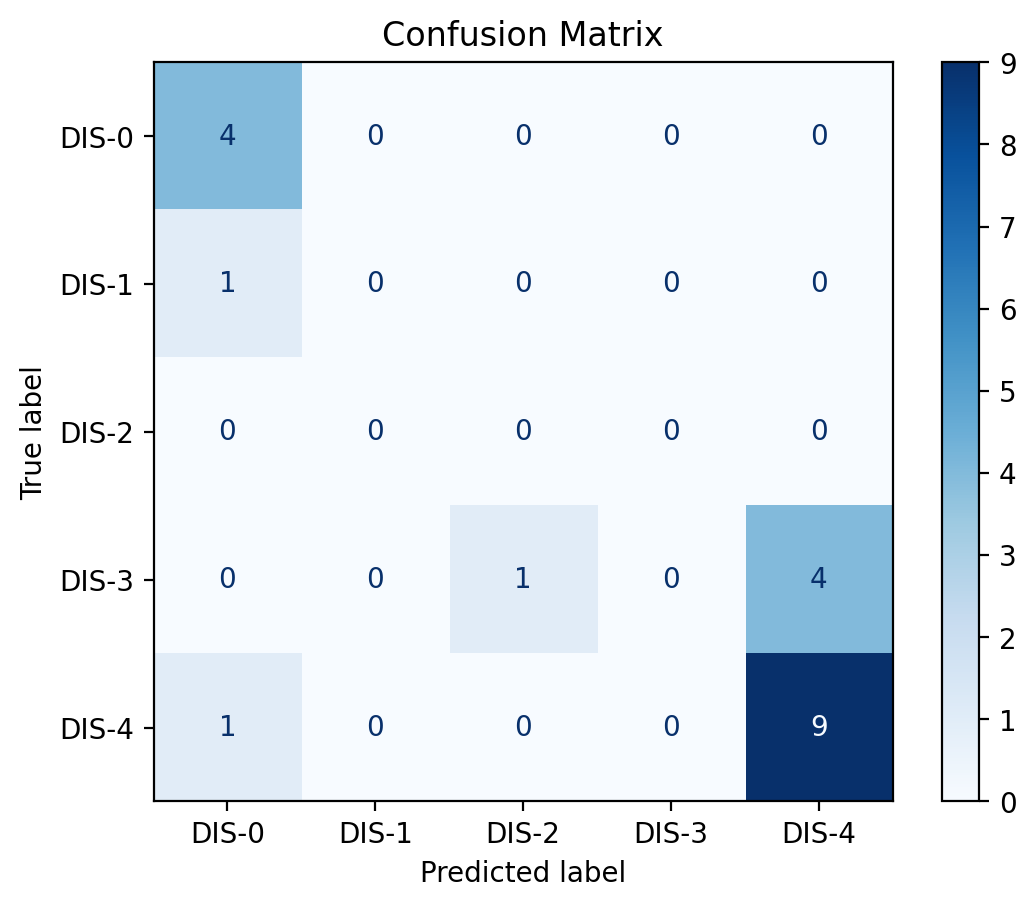

In [39]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [40]:
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

       DIS-0       0.67      1.00      0.80         4
       DIS-1       0.00      0.00      0.00         1
       DIS-2       0.00      0.00      0.00         0
       DIS-3       0.00      0.00      0.00         5
       DIS-4       0.69      0.90      0.78        10

    accuracy                           0.65        20
   macro avg       0.27      0.38      0.32        20
weighted avg       0.48      0.65      0.55        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\si

#### Predict the Choreoathetosis Duration Scores

In [41]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  17:04:37 29/05/2023
STC train estimate  17:05:16 29/05/2023
STC weight = 0.003269937214346719
DrCIF  17:05:41 29/05/2023
DrCIF train estimate  17:05:47 29/05/2023
DrCIF weight = 0.014636883087181647
Arsenal  17:06:18 29/05/2023
Arsenal train estimate  17:06:35 29/05/2023
Arsenal weight = 0.0001395881947248616
TDE  17:06:56 29/05/2023
TDE train estimate  17:06:56 29/05/2023
TDE weight = 0.023445456527099322


Create the confusion matrix

Confusion Matrix
[[4 1 1 0 0]
 [2 3 0 0 0]
 [0 4 0 1 0]
 [1 0 0 1 0]
 [1 0 1 0 0]]


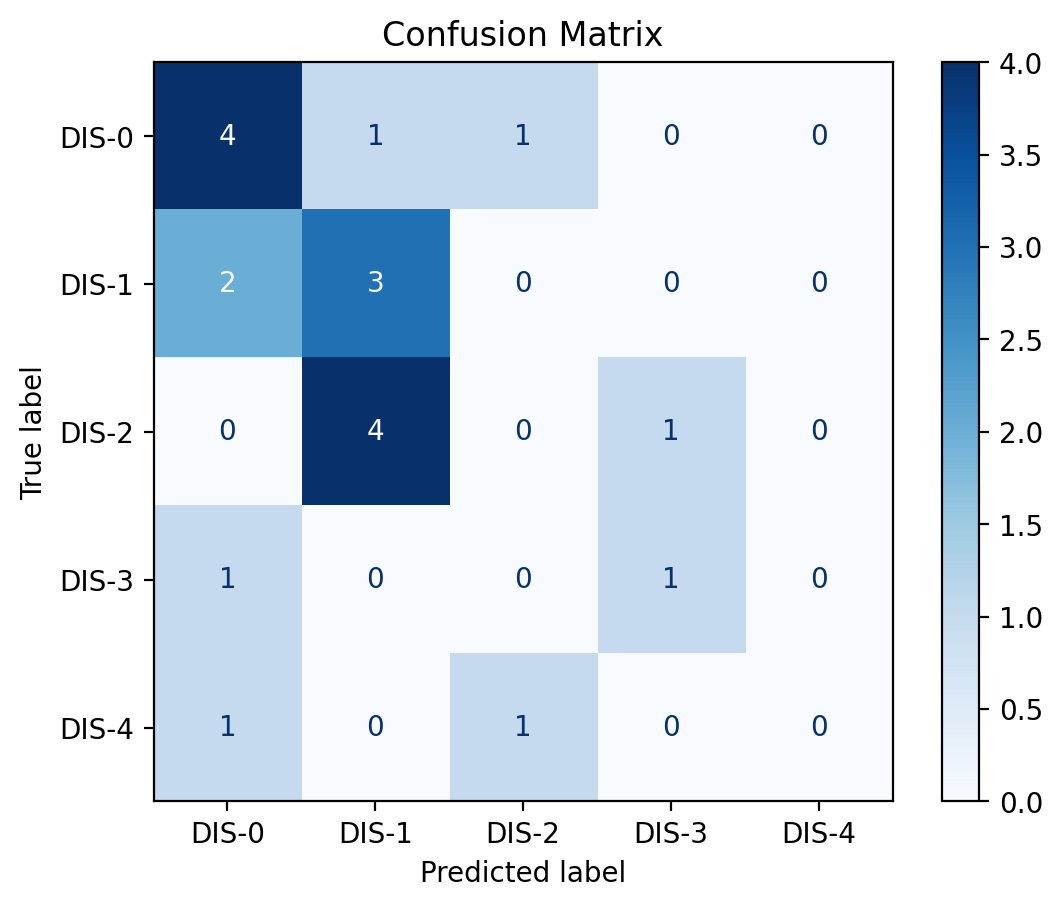

In [42]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.38      0.60      0.46         5
           2       0.00      0.00      0.00         5
           3       0.50      0.50      0.50         2
           4       0.00      0.00      0.00         2

    accuracy                           0.40        20
   macro avg       0.28      0.35      0.31        20
weighted avg       0.29      0.40      0.34        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict the Choreoathetosis Amplitude Scores

In [44]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  17:08:43 29/05/2023
STC train estimate  17:09:19 29/05/2023
STC weight = 0.003269937214346719
DrCIF  17:09:43 29/05/2023
DrCIF train estimate  17:09:49 29/05/2023
DrCIF weight = 0.006378845487258834
Arsenal  17:10:20 29/05/2023
Arsenal train estimate  17:10:37 29/05/2023
Arsenal weight = 0.006378845487258834
TDE  17:10:58 29/05/2023
TDE train estimate  17:10:58 29/05/2023
TDE weight = 0.018653672978584262


Create the confusion matrix

Confusion Matrix
[[0 4 1 0 0]
 [1 3 1 0 0]
 [1 4 1 0 0]
 [0 2 1 0 0]
 [0 1 0 0 0]]


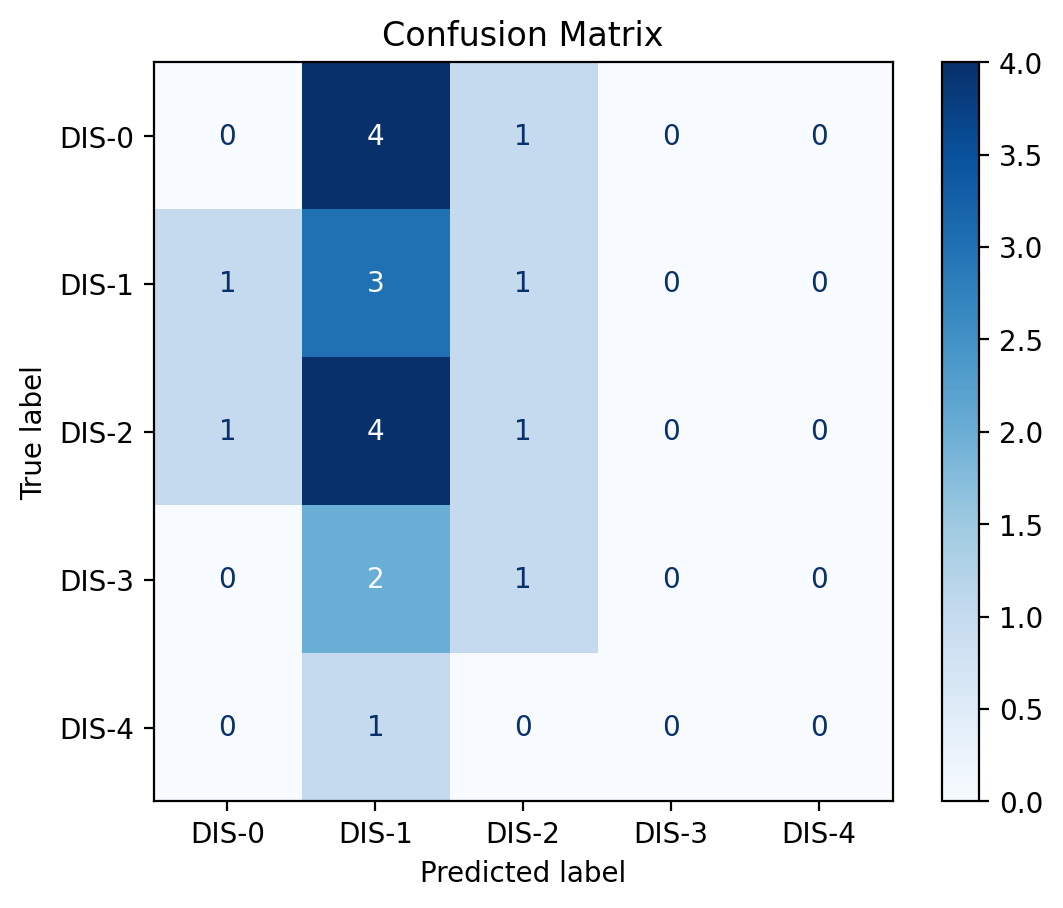

In [45]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.21      0.60      0.32         5
           2       0.25      0.17      0.20         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.20        20
   macro avg       0.09      0.15      0.10        20
weighted avg       0.13      0.20      0.14        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
